In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [10]:
tf.random.set_seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
look_back = 10
X, y = create_dataset(dataset, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

tscv = TimeSeriesSplit(n_splits=3)  # 3 folds is optimum

C:\Users\sruja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Train Score for this fold: 14.18 RMSE
Test Score for this fold: 22.64 RMSE


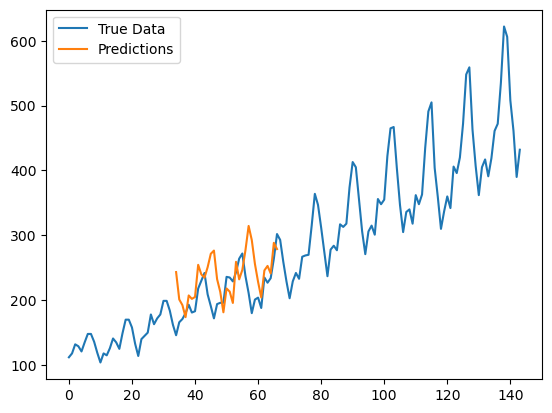

C:\Users\sruja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Train Score for this fold: 16.84 RMSE
Test Score for this fold: 54.23 RMSE


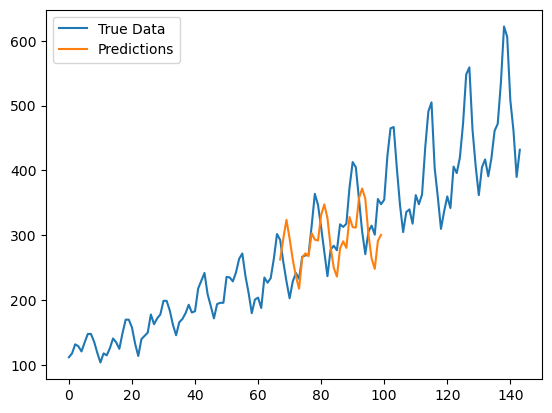

C:\Users\sruja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Train Score for this fold: 22.51 RMSE
Test Score for this fold: 45.23 RMSE


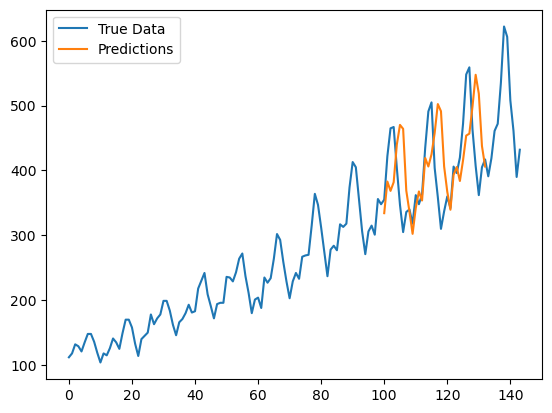

In [13]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model2 = Sequential()
    model2.add(LSTM(4,input_shape=(look_back, 1)))
    model2.add(Dense(1))
    model2.compile(loss='mean_squared_error', optimizer='adam')

    model2.fit(X_train, y_train, epochs=350, batch_size=1, verbose=0)

    trainPredict = model2.predict(X_train)
    testPredict = model2.predict(X_test)

    trainPredict = scaler.inverse_transform(trainPredict)
    y_train_inv = scaler.inverse_transform([y_train])
    testPredict = scaler.inverse_transform(testPredict)
    y_test_inv = scaler.inverse_transform([y_test])

    trainScore = np.sqrt(mean_squared_error(y_train_inv[0], trainPredict[:, 0]))
    print(f'Train Score for this fold: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(y_test_inv[0], testPredict[:, 0]))
    print(f'Test Score for this fold: {testScore:.2f} RMSE')

    plt.plot(scaler.inverse_transform(dataset), label='True Data')
    plt.plot(np.arange(len(trainPredict), len(trainPredict) + len(testPredict)), testPredict, label='Predictions')
    plt.legend()
    plt.show()

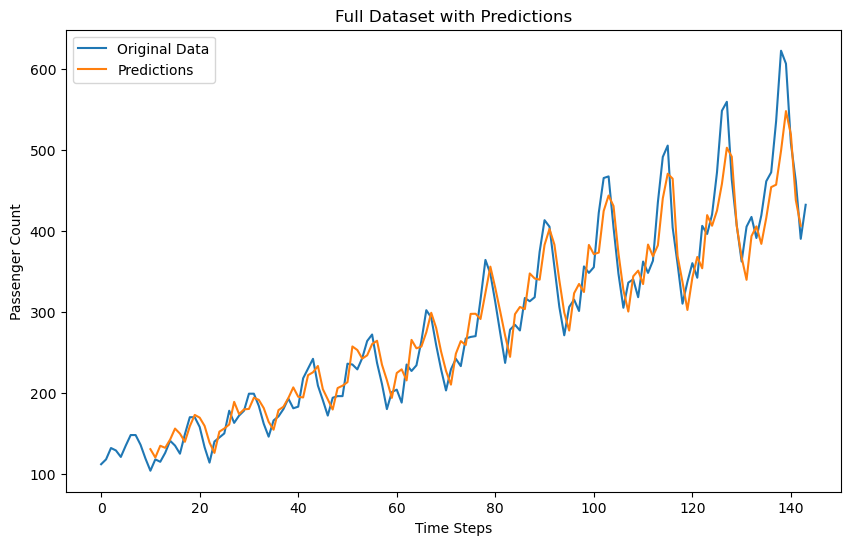

In [14]:
fullPredict = np.empty_like(dataset)
fullPredict[:, :] = np.nan

fullPredict[look_back:look_back + len(trainPredict), :] = trainPredict

fullPredict[len(trainPredict) + (look_back):len(trainPredict) + len(testPredict) + (look_back), :] = testPredict

plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label="Original Data")
plt.plot(fullPredict, label="Predictions")
plt.title("Full Dataset with Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()


In [15]:
print(f"Train RMSE: {trainScore:.2f}")
print(f"Test RMSE: {testScore:.2f}")

Train RMSE: 22.51
Test RMSE: 45.23


In [18]:
import joblib
joblib.dump(model2, 'model.pkl')

['model.pkl']